# Facebook Network Analysis
This notebook contains a social network analysis mainly executed with the library of NetworkX. In detail, the facebook circles (friends lists) of ten people will be examined and scrutinized in order to extract all kinds of valuable information. The dataset can be found in the [stanford website](http://snap.stanford.edu/data/ego-Facebook.html). Moreover, as known, a facebook network is undirected and has no weights because one user can become friends with another user just once. Looking at the dataset from a graph analysis perspective:
* Each node represents an anonymized facebook user that belongs to one of those ten friends lists.
* Each edge corresponds to the friendship of two facebook users that belong to this network. In other words, two users must become friends on facebook in order for them to be connected in the particular network.

Note: Nodes $0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980$ are the ones whose friends list will be examined. That means that they are in the spotlight of this analysis. Those nodes are considered the `spotlight nodes`

* Now, the necessary libraries are imported

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

* The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [2]:
facebook = pd.read_csv('data/facebook_combined.txt.gz', compression='gzip', sep=' ', names=['start_node', 'end_node'])
facebook

,start_node,end_node
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
88229,4026,4030
88230,4027,4031
88231,4027,4032
88232,4027,4038


* The graph is created from the `facebook` dataframe of the edges:

In [3]:
G = nx.from_pandas_edgelist(facebook, 'start_node', 'end_node')

## Visualizing the graph

Let's start our exploration by visualizing the graph. Visualization plays a
central role in exploratory data analysis to help get a qualitative feel for
the data.

Since we don't have any real sense of structure in the data, let's start by
viewing the graph with `random_layout`, which is among the fastest of the layout
functions.

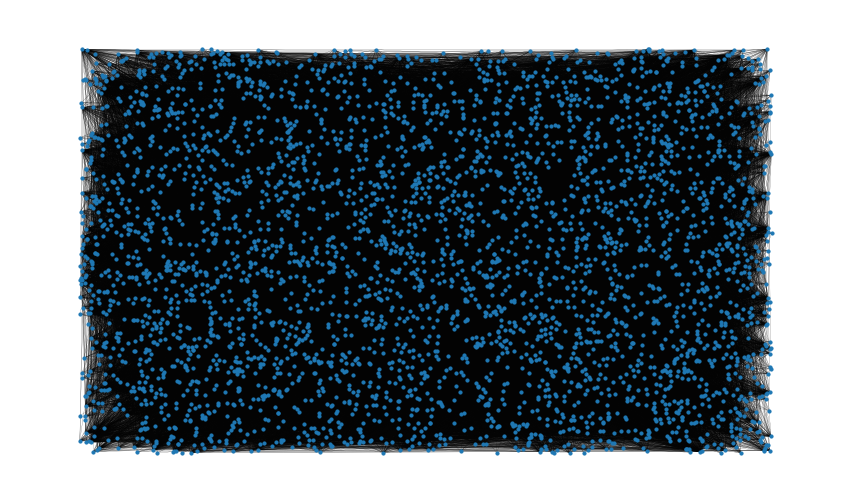

In [4]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

The resulting image is... not very useful. Graph visualizations of this kind
are sometimes colloquially referred to as "hairballs" due to the overlapping
edges resulting in an entangled mess.

It's clear that we need to impose more structure on the positioning of the if
we want to get a sense for the data. For this, we can use the `spring_layout`
function which is the default layout function for the networkx drawing module.
The `spring_layout` function has the advantage that it takes into account the
nodes and edges to compute locations of the nodes. The downside however, is
that this process is much more computationally expensive, and can be quite
slow for graphs with 100's of nodes and 1000's of edges.

Since our dataset has over 80k edges, we will limit the number of iterations
used in the `spring_layout` function to reduce the computation time.
We will also save the computed layout so we can use it for future
visualizations.

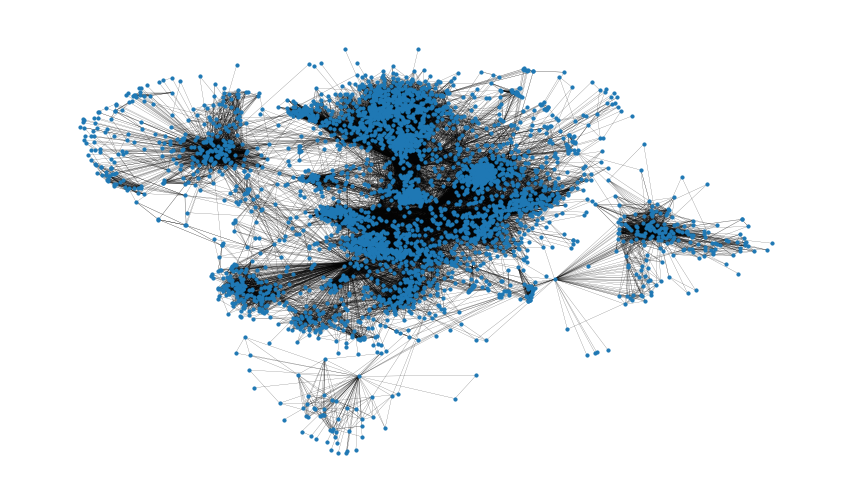

In [5]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

This visualization is much more useful than the previous one! Already we can
glean something about the structure of the network; for example, many of the
nodes seem to be highly connected, as we might expect for a social network.
We also get a sense that the nodes tend to form clusters. The `spring_layout`
serves to give a qualitative sense of clustering, but it is not designed for
repeatable, qualitative clustering analysis. We'll revisit evaluating
network clustering [later in the analysis](#clustering-effects)

## Basic topological attributes
* Total number of nodes in network:

In [6]:
G.number_of_nodes()

4039

* Total number of edges:

In [7]:
G.number_of_edges()

88234

Also, the average degree of a node can be seen. 
* On average, a node is connected to almost 44 other nodes, also known as neighbors of the node. 
* This has been calculated by creating a list of all the degrees of the nodes and using `numpy.array` to find the mean of the created list.

In [8]:
np.mean([d for _, d in G.degree()])

43.69101262688784

There are many interesting properties related to the distribution of *paths*
through the graph.
For example, the *diameter* of a graph represents the longest of the
shortest-paths that connect any node to another node in the Graph.
Similarly, the average path length gives a measure of the average number of
edges to be traversed to get from one node to another in the network.
These attributes can be calculated with the `nx.diameter` and
`nx.average_shortest_path_length` functions, respectively.
Note however that these analyses require computing the shortest path between
every pair of nodes in the network: this can be quite expensive for networks
of this size!
Since we're interested in several analyses involving the shortest path length
for all nodes in the network, we can instead compute this once and reuse the
information to save computation time.

Let's start by computing the shortest path length for all pairs of nodes in the
network:

In [9]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

`nx.all_pairs_shortest_path_length` returns a dict-of-dict that maps a node `u`
to all other nodes in the network, where the inner-most mapping returns the
length of the shortest path between the two nodes.
In other words, `shortest_path_lengths[u][v]` will return the shortest path
length between any two pair of nodes `u` and `v`:

In [10]:
shortest_path_lengths[0][42]  # Length of shortest path between nodes 0 and 42

1

Now let's use `shortest_path_lengths` to perform our analyses, starting with
the *diameter* of `G`.
If we look carefully at the [docstring for `nx.diameter`][nx_diameter_], we see
that it is equivalent to the maximum *eccentricity* of the graph.
It turns out that `nx.eccentricity` has an optional argument `sp` where we can
pass in our pre-computed `shortest_path_lengths` to save the extra computation:

In [11]:
# This is equivalent to `diameter = nx.diameter(G), but much more efficient since we're
# reusing the pre-computed shortest path lengths!
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

8

[nx_diameter_]: https://networkx.org/documentation/latest/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html

In order to connect from one node to any other one we would have to traverse 8
edges or fewer.

Next up, the average path length is found.
Again, we could use `nx.average_shortest_path_length` to compute this
directly, but it's much more efficient to use the `shortest_path_length` that
we've already computed:

In [12]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

3.691592636562027

This represents the average of the shortest path length for all pairs of nodes:
in order to reach from one node to another node, roughly 3.6 edges will be
traversed on average.

The above measures capture useful information about the network, but metrics
like the average value represent only a moment of the distribution; it is
also often valuable to look at the *distribution* itself.
Again, we can construct a visualization of the distribution of shortest path
lengths from our pre-computed dict-of-dicts:

Text(0, 0.5, 'Frequency (%)')

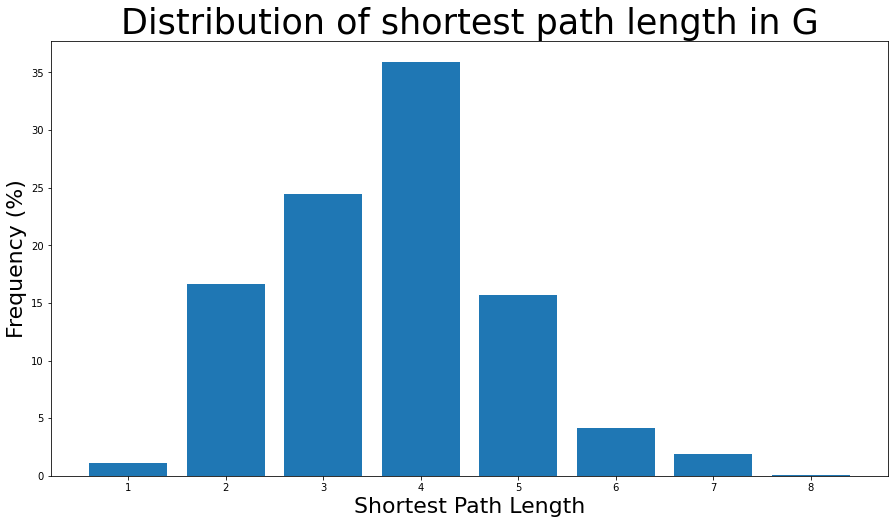

In [13]:
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    'Distribution of shortest path length in G', fontdict ={'size': 35}, loc='center'
)
ax.set_xlabel('Shortest Path Length', fontdict ={'size': 22})
ax.set_ylabel('Frequency (%)', fontdict ={'size': 22})

The majority of the shortest path lengths are from $2$ to $5$ edges long.
Also, it's highly unlikely for a pair of nodes to have a shortest path of length 8 (diameter length) as the likelihood is less than $0.1$%.

* The graph's density is calculated here. Clearly, the graph is a very sparse one as: $density < 1$

In [14]:
nx.density(G)

0.010819963503439287

* The graph's number of components are found below. As expected, the network consists of one giant compoenent:

In [15]:
nx.number_connected_components(G)

1

## Centrality measures
Now the centrality measures will be examined for the facebook graph

### Degree Centrality
Degree centrality assigns an importance score based simply on the number of links held by each node. In this analysis, that means that the higher the degree centrality of a node is, the more edges are connected to the particular node and thus the more neighbor nodes (facebook friends) this node has. In fact, the degree of centrality of a node is the fraction of nodes it is connected to. In other words, it is the percentage of the network that the particular node is connected to meaning being friends with.
* Starting, we find the nodes with the highest degree centralities. Specifically, the nodes with the 8 highest degree centralities are shown below together with the degree centrality:

In [16]:
degree_centrality = nx.centrality.degree_centrality(G)  # save results in a variable to use again 
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.258791480931154),
 (1684, 0.1961367013372957),
 (1912, 0.18697374938088163),
 (3437, 0.13546310054482416),
 (0, 0.08593363051015354),
 (2543, 0.07280832095096582),
 (2347, 0.07206537890044576),
 (1888, 0.0629024269440317)]

That means that node $107$ has the highest degree centrality with $0.259$, meaning that this facebook user is friends with around the 26% of the whole network. Similarly, nodes $1684, 1912, 3437$ and $0$ also have very high degree centralities. However, that is well expected as those nodes are the ones whose facebook circles we examine. Very interesting is the fact that the nodes $2543, 2347, 1888$ have some of the top 8 highest degree centralities even though we do not investigate their circles. In other words, those three nodes are very popular among the circles we examine now, meaning they have the most facebook friends inside this network apart from the spotlight nodes.
* Now we can also see the number of neighbors for the nodes with the highest degree centralities:

In [17]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[(107, 1045),
 (1684, 792),
 (1912, 755),
 (3437, 547),
 (0, 347),
 (2543, 294),
 (2347, 291),
 (1888, 254)]

As expected, node $107$ has $1045$ facebook friends which is the most any facebook user has in this analysis. Moreover, nodes $1684$ and $1912$ have more than $750$ facebook friends in this network. Also, nodes $3437$ and $0$ have the following highest number of facebook friends in this network with $547$ and $347$ respectively. Lastly, the two most popular friends of spotlight nodes have around $290$ facebook friends in this network.


Now the distribution of degree centralities will be plotted:

Text(0, 0.5, 'Counts')

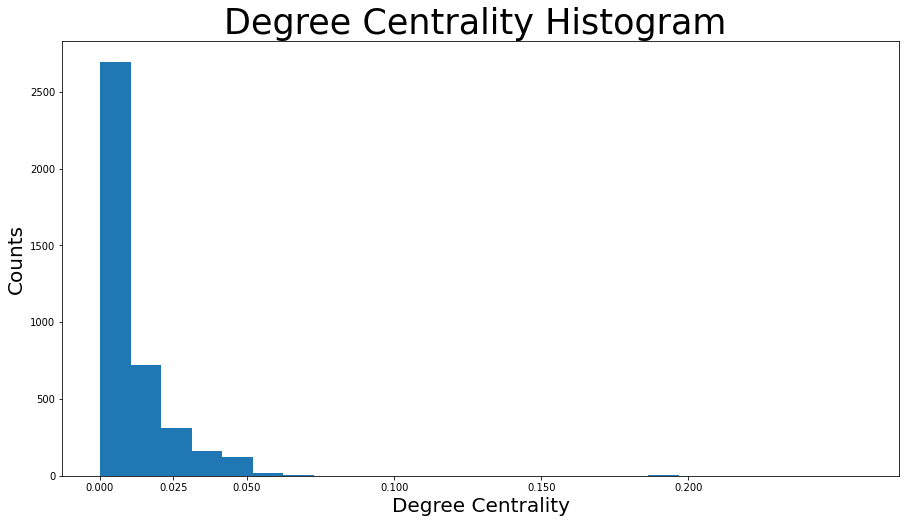

In [18]:
plt.figure(figsize=(15,8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title('Degree Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Degree Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

It is visible that the vast majority of facebook users have degree centralities of less than $0.05$. In fact the majority has less than $0.0125$. Actually, that makes sense because the network consists of friends lists of particular nodes, which are obviously the ones with the highest degree centralities. In other words, because only the friends list of particular nodes were used to create this particular network, plenty of nodes have extremely low degree centralities as they are not very interconnected in this network

Now let's check the users with highest degree centralities from the size of their nodes:

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

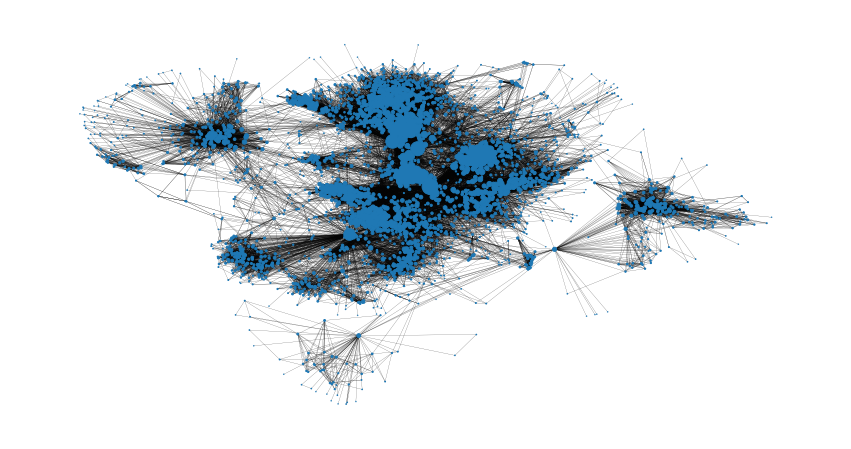

In [19]:
node_size =  [v * 1000 for v in degree_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

### Betweenness Centrality
Betweenness centrality measures the number of times a node lies on the shortest path between other nodes, meaning it acts as a bridge. In detail, betweenness centrality of a node $v$ is the percentage of all the shortest paths of any two nodes (apart from $v$), which pass through $v$. Specifically, in the facebook graph this measure is associated with the user's ability to influence others. A user with a high betweenness centrality acts as a bridge to many users that are not friends and thus has the ability to influence them by conveying information (e.g. by posting something or sharing a post) or even connect them via the user's circle (which would reduce the user's betweeness centrality after).
* Now, the nodes with the $8$ highest betweenness centralities will be calculated and shown with their centrality values:

In [20]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)  # save results in a variable to use again 
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.4805180785560152),
 (1684, 0.3377974497301992),
 (3437, 0.23611535735892905),
 (1912, 0.2292953395868782),
 (1085, 0.14901509211665306),
 (0, 0.14630592147442917),
 (698, 0.11533045020560802),
 (567, 0.09631033121856215)]

Looking at the results, the node $107$ has a betweenness centrality of $0.48$, meaning it lies on almost half of the total shortest paths between other nodes. Also, combining the knowledge of the degree centrality:
* Nodes $0, 107, 1684, 1912, 3437$ have both the highest degree and betweenness centralities and are `spotlight nodes`. That indicates that those nodes are both the most popular ones in this network and can also influence and spread information in the network. However, those are some of the nodes whose friends list consist the network and as a result it is an expected finding.
* Nodes $567, 1085$ are not spotlight nodes, have some of the highest betweenness centralities and have not the highest degree centralities. That means that even though those nodes are not the most popular users in the network, they have the most influence in this network among friends of spotlight nodes when it comes to spreading information.
* Node $698$ is a `spotlight node` and has a very high betweenness centrality even though it has not the highest degree centralities. In other words, this node does not have a very large friends list on facebook. However, the user's whole friend list is a part of the network and thus the user could connect different circles in this network by being the middleman.

Moving on, the distribution of betweenness centralities will be plotted:

Text(0, 0.5, 'Counts')

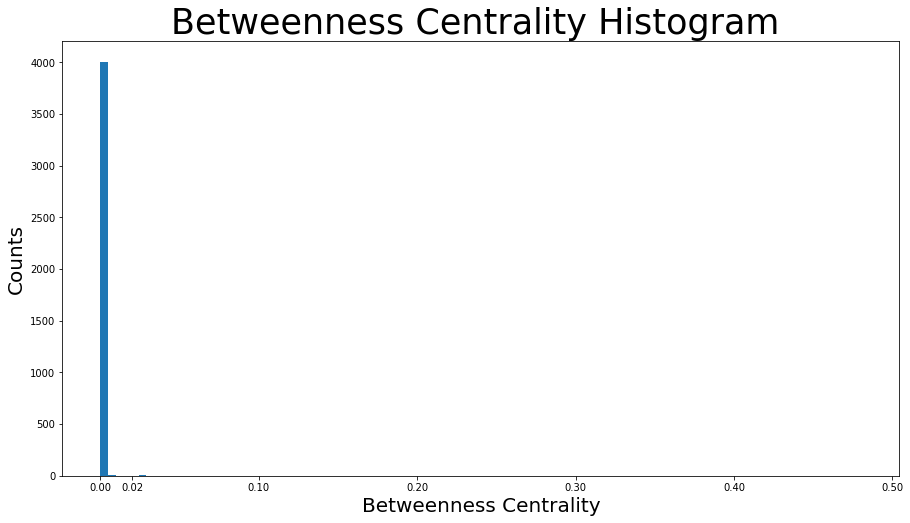

In [21]:
plt.figure(figsize=(15,8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title('Betweenness Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Betweenness Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

As we can see, the vast majority of betweenness centralities is below $0.01$. That makes sense as the graph is very sparse and thus most nodes do not act as bridges in shortest paths. However, that also results in some nodes having extremely high betweenness centralities as for example node $107$ with $0.48$ and node $1684$ with $0.34$ betweenness centrality.

We can also get an image on the nodes with the highest betweenness centralities and where they are located in the network. It is clear that they are the bridges from one community to another:

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

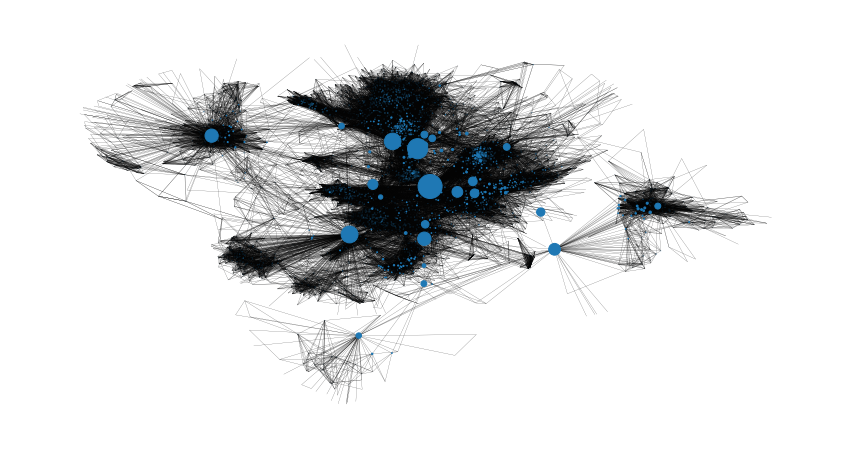

In [22]:
node_size =  [v * 1200 for v in betweenness_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

### Closeness Centrality
Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network. For a node $v$, its closeness centrality measures the average farness to all other nodes. In other words, the higher the closeness centrality of $v$, the closer it is located to the center of the network.

The closeness centrality measure is very important for the monitoring of the spread of false information (e.g. fake news) or viruses (e.g. malicious links that gain control of the facebook account in this case). Let's examine the example of fake news. If the user with the highest closeness centrality measure started spreading some fake news information (sharing or creating a post), the whole network would get missinformed the quickest possible. However, if a user with very low closeness centrality would try the same, the spread of the missinformation to the whole network would be much slower. That is because the false information would have to firstly reach a user with high closeness centrality that would spread it to many different parts of the network.
* The nodes with the highest closeness centralities will be found now:

In [23]:
closeness_centrality = nx.centrality.closeness_centrality(G)  # save results in a variable to use again 
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.45969945355191255),
 (58, 0.3974018305284913),
 (428, 0.3948371956585509),
 (563, 0.3939127889961955),
 (1684, 0.39360561458231796),
 (171, 0.37049270575282134),
 (348, 0.36991572004397216),
 (483, 0.3698479575013739)]

Inspecting the users with the highest closeness centralities, we understand that there is not a huge gap between them in contrast to the previous metrics. Also, the nodes $107, 1684, 348$ are the only `spotlight nodes` found in the ones with the highest closeness centralities. That means that a node that has many friends is not necessary close to the center of the network.

Also, the average distance of a particular node $v$ to any other node can be found easily with the formula:

$$\frac{1}{closeness\,centrality(v)}$$

In [24]:
1 / closeness_centrality[107]

2.1753343239227343

The distance from node $107$ to a random node is around two hops


Furthermore, the distribution of the closeness centralities:

Text(0, 0.5, 'Counts')

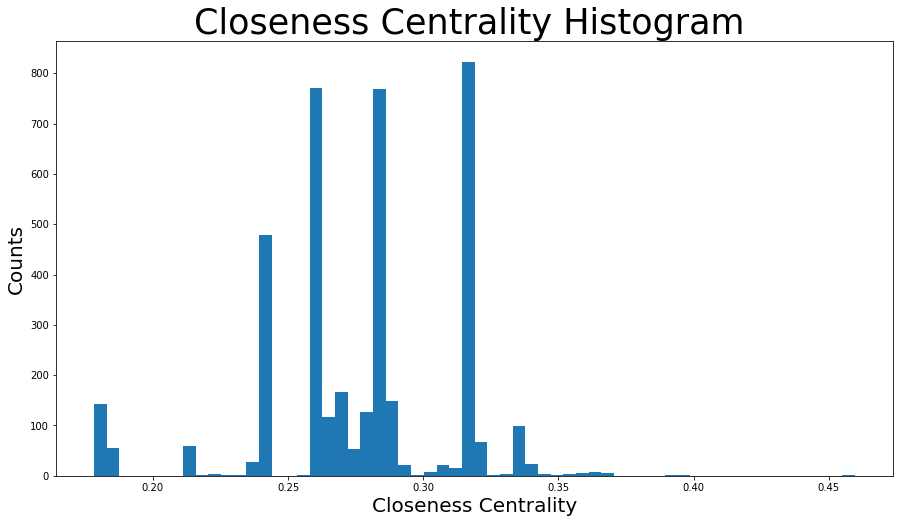

In [25]:
plt.figure(figsize=(15,8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title('Closeness Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Closeness Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

The closeness centralities are distributed over various values from $0.17$ to $0.46$. In fact, the majority of them are found between $0.25$ and $0.3$. That means that the majority of nodes are relatively close to the center of the network and thus close to other nodes in general. However, there are some communities that are located further away, whose nodes would have the minimum closeness centralities, as seen below:

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

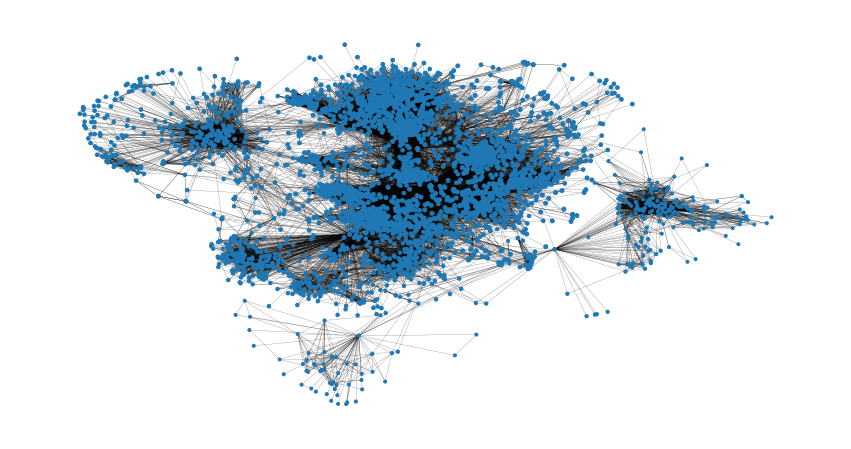

In [26]:
node_size =  [v * 50 for v in closeness_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

### Eigenvector Centrality
Eigenvector centrality is the metric to show how connected a node is to other important nodes in the network. It measures a node's influence based on how well it is connected inside the network and how many links its connections have and so on. This measure can identify the nodes with the most influence over the whole network. A high eigenvector centrality means that the node is connected to other nodes who themselves have high eigenvector centralities. In this facebook analysis, the measure is associated with the users ability to influence the whole graph and thus the users with the highest eigenvector centralities are the most important nodes in this network.

* The nodes with the highest eigenvector centralities will be examined now:

In [27]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(G)  # save results in a variable to use again 
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(1912, 0.09540696149067629),
 (2266, 0.08698327767886552),
 (2206, 0.08605239270584342),
 (2233, 0.08517340912756598),
 (2464, 0.08427877475676092),
 (2142, 0.08419311897991796),
 (2218, 0.0841557356805503),
 (2078, 0.08413617041724979),
 (2123, 0.08367141238206226),
 (1993, 0.0835324284081597)]

Checking the results:
* Node $1912$ has the highest eigenvector centrality with $0.095$. This node is also a `spotlight node` and can surely be considered the most important node in this network in terms of overall influence to the whole network. In fact, this node also has some of the highest degree centralities and  betweenness centralities, making the user very popular and influencious to other nodes. 
* Nodes $1993, 2078, 2206, 2123, 2142, 2218, 2233, 2266, 2464$, even though they are not spotlight nodes, have some of the highest eigenvector centralities with around $0.83-0.87$. Very interesting is the fact that all those nodes are identified for the first time, meaning they have neither the heighest degree, betweenness or closeness centralities in this graph. That leads to the conclusion that those nodes are very likely to be connected to the node $1912$ and as a result have very high eigenvector centralities.

Checking if those nodes are connected to the most important node $1912$, the hypothesis is correct:

In [28]:
high_eigenvector_centralities = ((sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[1:10])  # 2nd to 10th nodes with heighest eigenvector centralities
high_eigenvector_nodes = [tuple[0] for tuple in high_eigenvector_centralities]  # set list as [2266, 2206, 2233, 2464, 2142, 2218, 2078, 2123, 1993]
neighbors_1912 = [n for n in G.neighbors(1912)]  # list with all nodes connected to 1912
all(item in neighbors_1912 for item in high_eigenvector_nodes)  # check if items in list high_eigenvector_nodes exist in list neighbors_1912

True

Let's check the distribution of the eigenvector centralities:

Text(0, 0.5, 'Counts')

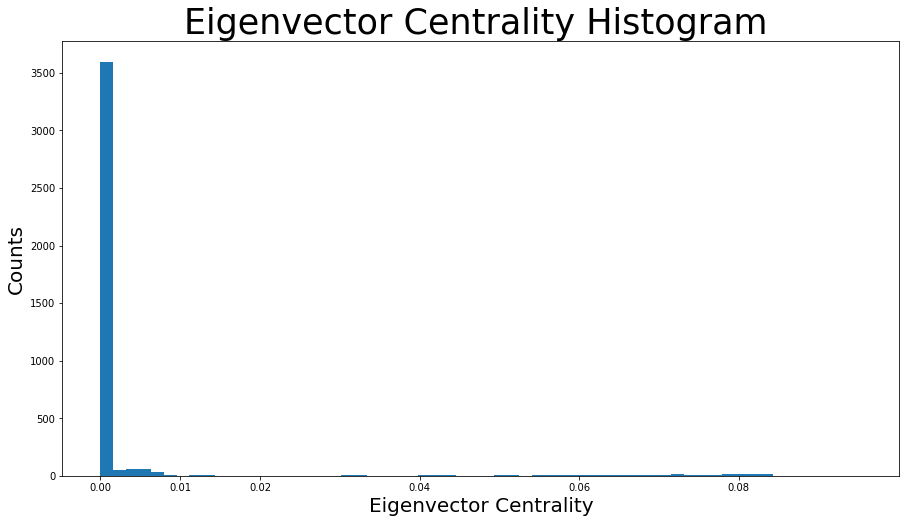

In [29]:
plt.figure(figsize=(15,8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])  # set the x axis ticks
plt.title('Eigenvector Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Eigenvector Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

As shown in the distribution histogram, the vast majority of eigenvector centralities are below $0.005$ and are actually almost $0$. However, we can also see different values of eigenvector centralities as there are tiny bins all over the x axis.

Now we can identify the eigenvector centralities of nodes based on their size in the following representation:

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

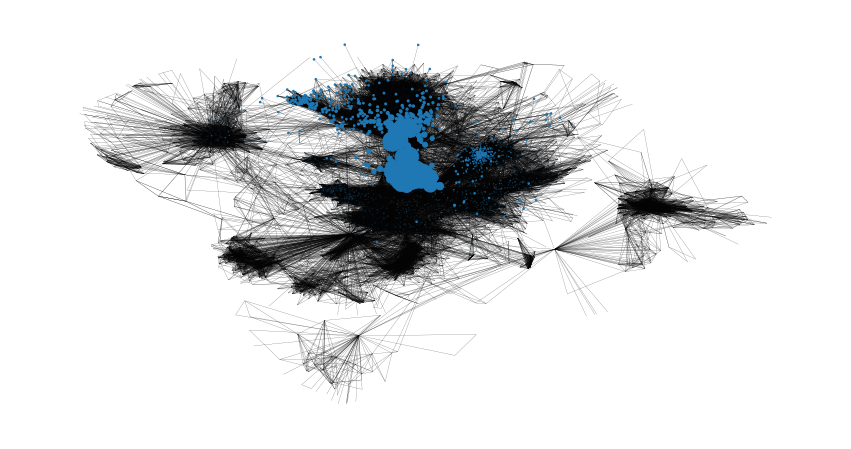

In [30]:
node_size =  [v * 4000 for v in eigenvector_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

## Clustering Effects
The clustering coefficient of a node $v$ is defined as the probability that two randomly selected friends of $v$ are friends with each other. As a result, the average clustering coefficient is the average of clustering coefficients of all the nodes. The closer the average clustering coefficient is to $1$, the more complete the graph will be because there's just one giant component. Lastly, it is a sign of triadic closure because the more complete the graph is, the more triangles will usually arise.

In [31]:
nx.average_clustering(G)

0.6055467186200876

Now the clustering coefficient distribution will be displayed:

Text(0, 0.5, 'Counts')

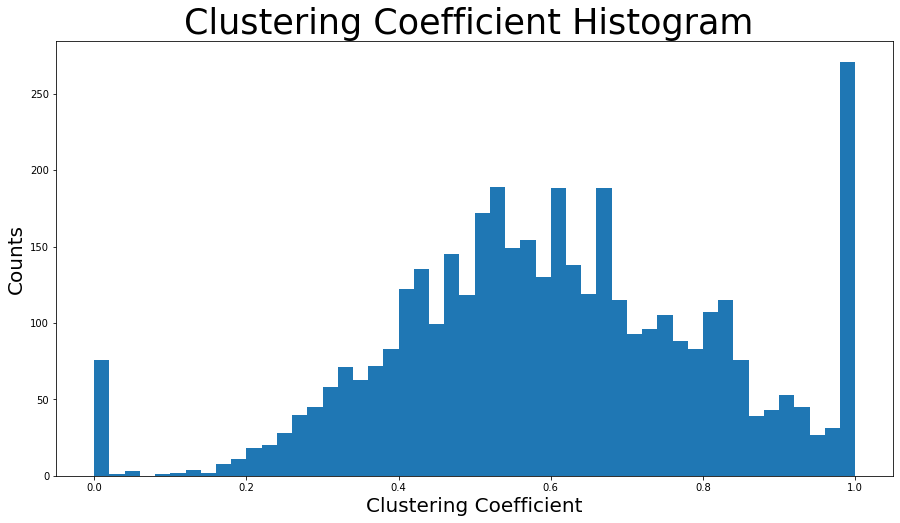

In [32]:
plt.figure(figsize=(15,8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title('Clustering Coefficient Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Clustering Coefficient', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

 $50$ bins were used to showcase the distribution. The bin with the highest counts concerns nodes with clustering coefficient close to $1$ as there are more than two-hundred-fifty nodes in that bin. In addition, the bins of clustering coefficient between $0.4$ and $0.8$ contain the majority of nodes by far. 
 
 The number of unique triangles in the network are found next:

In [33]:
triangles_per_node = list(nx.triangles(G).values())
sum(triangles_per_node) / 3  # divide by 3 because each triangle is counted once for each node

1612010.0

 Now the average number of triangles that a node is a part of:

In [34]:
np.mean(triangles_per_node)

1197.3334983906907

Due to having some nodes that belong to a great many triangles, the metric of median will give us a better understanding:

In [35]:
np.median(triangles_per_node)

161.0

In fact, the median value is just $161$ triangles, when the mean is around $1197$ triangles that a node is part of. That means that the majority of nodes of the network belong to extremely few triangles, whereas some nodes are part of a plethora of triangles (which are extreme values that increase the mean)

In conclusion, the high average clustering coefficient together with the huge number of triangles are signs of the triadic closure. In detail, the triadic closure means that as time goes on, new edges tend to form between two users that have one or more mutual friends. That can be explained by the fact that Facebook usually suggests new friends to a user when there are many mutual friends between the user and the new friend to be added. Also, there is a source of latent stress. For example, if node $A$ is friends with
node $B$ and $C$,  some tension builds up if $B$ and $C$ are not friends with each other.

## Bridges
First of all, an edge joining two nodes A and B in the graph is considered a bridge, if deleting the edge would cause A and B to lie in two different components. Now it is checked if there are any bridges in this network:

In [36]:
nx.has_bridges(G)

True

Actually, there are bridges in the network. Now the edges that are bridges will be saved in a list and the number of them is printed:

In [37]:
bridges = list(nx.bridges(G))
len(bridges)

75

The existence of so many bridges is due to the fact that this network only contains the spotlight nodes and the friends of them. As a result, some friends of spotlight nodes are only connected to a spotlight node, making that edge a bridge.

Also, the edges that are local bridges are saved in a list and their number is printed. In detaill, an edge joining two nodes $C$ and $D$ 
in a graph is a local bridge, if its endpoints $C$ and $D$ have no friends in common. Very importantly, an edge that is a bridge is also a local bridge. Thus, this list contains all the above bridges as well:

In [38]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

78

Showcasing the bridges and local bridges in the network now. The bridges can be seen with the red color and the local bridges with the green color. Black edges are neither local bridges nor bridges.

* It is clear that all the bridges concern nodes that are only connected to a spotlight node (have a degree of $1$)

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

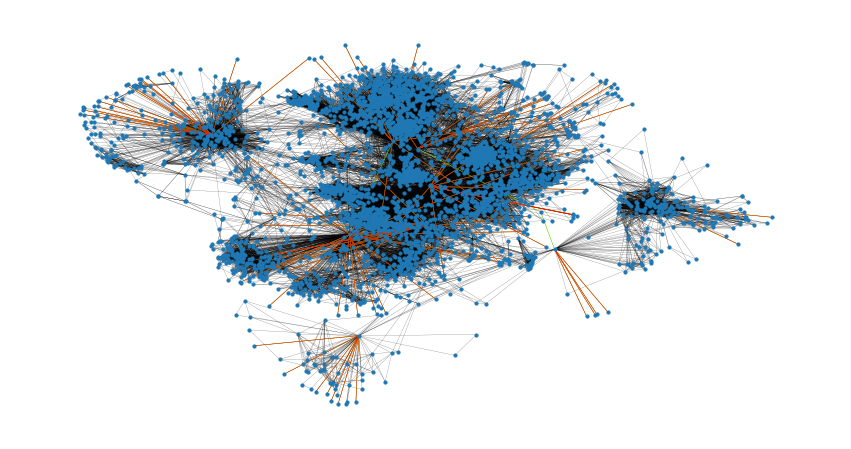

In [39]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen")  # green color for local bridges 
nx.draw_networkx_edges(G, pos, edgelist=bridges, width=0.5, edge_color="r")  # red color for bridges
plt.axis('off')

## Assortativity
Assortativity describes the preference for a network's nodes to attach to others that are similar in some way.
* The assortativity in terms of nodes degrees is found with two ways:

In [40]:
nx.degree_assortativity_coefficient(G)

0.06357722918564943

In [41]:
nx.degree_pearson_correlation_coefficient(G)  # use the potentially faster scipy.stats.pearsonr function.

0.06357722918564918

In fact, the assortativity coefficient is the Pearson correlation coefficient of degree between pairs of linked nodes. That means that it takes values from $-1$ to $1$. In detail, a positive assortativity coefficient indicates a correlation between nodes of similar degree, while a negative indicates correlation between nodes of different degrees.

In our case the assortativity coefficient is around $0.064$, which is almost 0. That means that the network is almost non-assortative, and we cannot correlate linked nodes based on their degrees. In other words, we can not draw conclusions on the number of friends of a user from his/her friends' number of friends (friends degree). That makes sense since we only use the friends list of spotlight nodes, non spotlight nodes will tend to have much fewer friends.

## Network Communities
A community is a group of nodes, so that nodes inside the group are connected with many more edges than between groups. Two different algorithms will be used for communities detection in this network
* Firstly, a semi-synchronous label propagation method[^1] is used to detect the communities.

This function determines by itself the number of communities that will be detected. Now the communities will be iterated through and a colors list will be created to contain the same color for nodes that belong to the same community. Also, the number of communities is printed:

In [42]:
colors = ['' for x in range (G.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = '#%06X' % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(com):  # fill colors list with the particular color for the community nodes
        colors[node] = color
counter

44

In detail, $44$ communities were detected. Now the communities are showcased in the graph. Each community is depicted with a different color and its nodes are usually located close to each other:

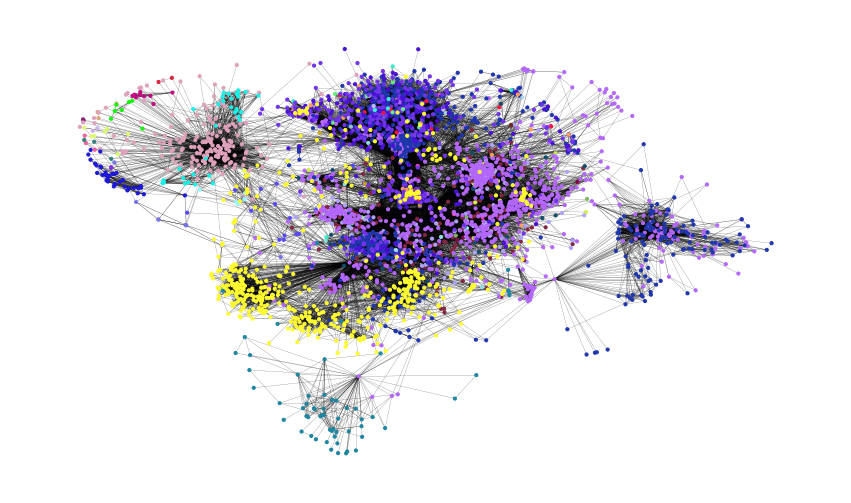

In [43]:
plt.figure(figsize=(15,9))
plt.axis('off') 
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors)

* Next, the asynchronous fluid communities algorithm is used. 

With this function, we can decide the number of communities to be detected. Let's say that $8$ communities is the number we want. Again, the communities will be iterated through and a colors list will be created to contain the same color for nodes that belong to the same community.

In [44]:
colors = ['' for x in range (G.number_of_nodes())]
for com in nx.community.asyn_fluidc(G, 8, seed=0):
    color = '#%06X' % randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        colors[node] = color

Now the $8$ communities are shown in the graph. Again, each community is depicted with a different color:

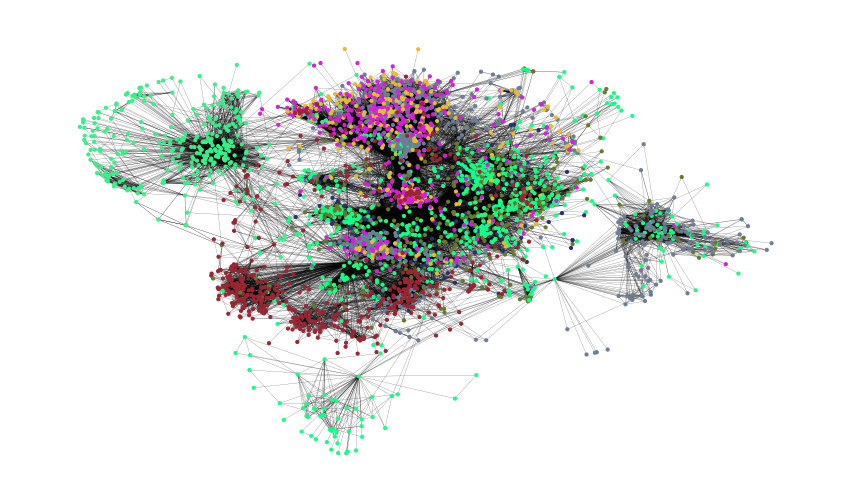

In [45]:
plt.figure(figsize=(15,9))
plt.axis('off') 
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors)

### References
[Cambridge-intelligence](https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/#:~:text=Centrality%20measures%20are%20a%20vital,but%20they%20all%20work%20differently.)

[^1]: [Semi-synchronous label propagation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html#networkx.algorithms.community.label_propagation.label_propagation_communities)

[^2]: [Asynchronous fluid communities algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.asyn_fluid.asyn_fluidc.html#networkx.algorithms.community.asyn_fluid.asyn_fluidc)